# Introduction
* **Note: Turn on your GPU.**
* In this kernel we will generate new audio using **simple GANs**. 
* Our instrument will be **Saxophone**.

### If you do not know **simple GANs** you can check this kernel: 

<div class="row">
  <div class="col-sm-4">
    <div class="card">
      <div class="card-body" style="width: 30rem;">
         <h5 class="card-title"><u>Fashion Dataset GANs</u></h5>
         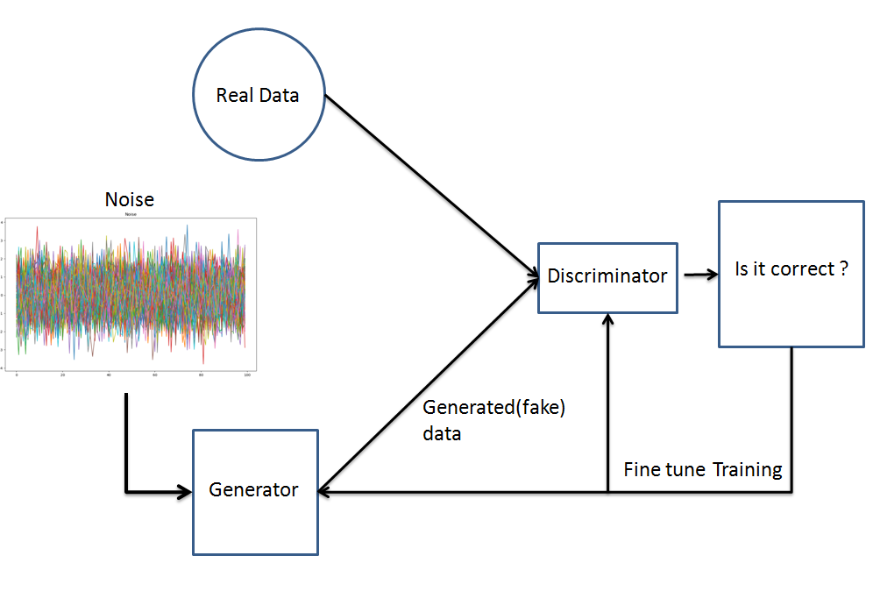<br>
         <p class="card-text">A kernel about generating clothes using traditional GANs</p>
         <a href="https://www.kaggle.com/mrhippo/fashion-dataset-gans" class="btn btn-primary" style="color:white;">Go to Post</a>
      </div>
    </div>
  </div> 
</div>


<hr>


## Content
* We are using [Freesound General-Purpose Audio Tagging Challenge](https://www.kaggle.com/c/freesound-audio-tagging/data) dataset.


* [Imports](#1)
* [Preparing the Data](#2)
* [Data Exploration](#3)
* [Bulding GANs Model](#4)
* [Training](#5)
* [Results](#6)
* [Conclusion](#7)

<a id="1"></a> <br>
# Imports

In [ ]:
# data science and mathematical operations
import numpy as np
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import IPython
import IPython.display as ipd 

# deep learning
from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import models

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id="2"></a> <br>
# Preparng the Data 

In [ ]:
# Audio Config
DURATION = 4
SAMPLE_RATE = 16000
AUDIO_SHAPE = SAMPLE_RATE*DURATION

MFCC = 40

# Paths
DATASET_PATH = "../input/freesound-audio-tagging/"

# Load 
def load_train_data(label, input_length=AUDIO_SHAPE):
    train = pd.read_csv(DATASET_PATH + "train.csv")
    if label != None:
        train_list = train.loc[train.label == label]
    else: 
        train_list = train
    cur_batch_size = len(train_list)
    train_fname_list = train_list.fname
    X = np.empty((cur_batch_size, input_length))
    for i, train_fname in enumerate(train_fname_list):
        file_path = DATASET_PATH + "audio_train/" + train_fname
        
        # Read and Resample the audio
        data, _ = librosa.core.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        X[i,] = data
    print("Data Loaded...")
    return X

# Stardize Data 
def normalization(X):
    mean = X.mean(keepdims=True)
    std = X.std(keepdims=True)
    X = (X - mean) / std
    print("Data Normalized...")
    return X

# Rescale Data to be in range [rangeMin, rangeMax]
def rescale(X, rangeMin=-1, rangeMax=+1):
    maxi = X.max()
    mini = X.min()
    X = np.interp(X, (mini, maxi), (rangeMin, rangeMax))
    print("Data Rescaled...")
    return X

In [ ]:
train_data = normalization(load_train_data("Saxophone", AUDIO_SHAPE))

In [ ]:
x_train = rescale(train_data)

In [ ]:
asd

<a id="3"></a> <br>
# Data Exploration

In [ ]:
audio_samples = [x_train[0], x_train[2], x_train[10], x_train[20], x_train[42], x_train[100]] 

for audio in audio_samples:
        IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))

In [ ]:
length_of_audio_samples = len(audio_samples)
fig, ax = plt.subplots(int(length_of_audio_samples/2),2, figsize = (16,length_of_audio_samples*3)) 
    
# drwing plots
count = 0
for r in range(0,int(length_of_audio_samples/2)):
    for c in range(0,2):
        sample = audio_samples[count]
        ax[r,c].plot(sample)
        count += 1
        ax[r,c].set_xlabel("Samples")
        
fig.suptitle("Saxophone Samples", fontsize = 17)
plt.show()

In [ ]:
length_of_audio_samples = len(audio_samples)
fig, ax = plt.subplots(int(length_of_audio_samples/2),2, figsize = (16,length_of_audio_samples*2)) 
    
# drwing plots
count = 0
for r in range(0,int(length_of_audio_samples/2)):
    for c in range(0,2):
        sample = audio_samples[count]
        mfcc = librosa.feature.mfcc(sample, sr = SAMPLE_RATE, n_mfcc=40)
        ax[r,c].imshow(mfcc, cmap='hot', interpolation='nearest');
        count += 1
        
fig.suptitle("Saxophone Samples MFCCs", fontsize = 17)
plt.show()

<a id="4"></a> <br>
# Bulding GANs Model

## Generator

* **Our Generator's diagram:**

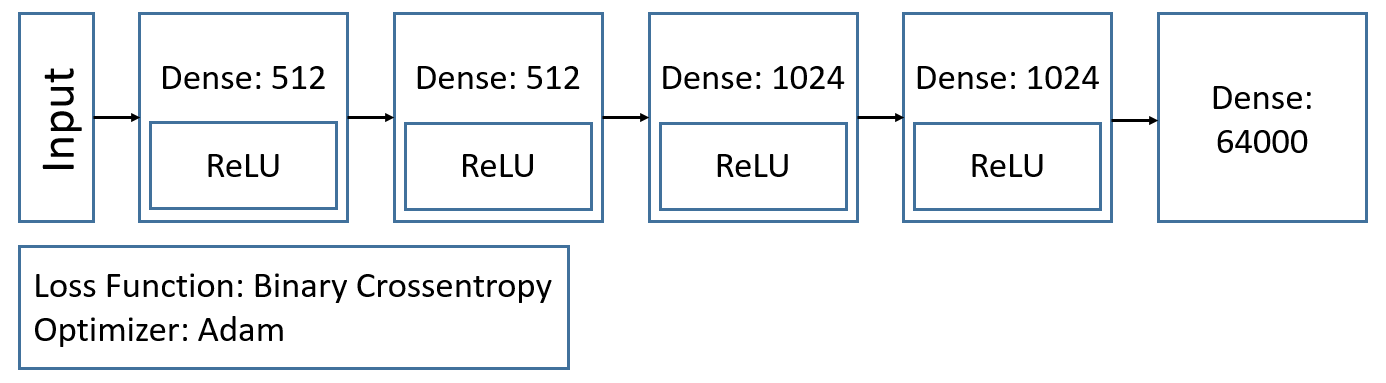 

In [ ]:
def create_generator():
    
    generator = Sequential()
    generator.add(Dense(units = 512, input_dim = 100))
    generator.add(ReLU())
    
    generator.add(Dense(units = 512))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = 64000))
    
    generator.compile(loss ="binary_crossentropy",
                     optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    
    return generator

g = create_generator()
g.summary()

## Discriminator

* **Our Discriminator's diagram:**

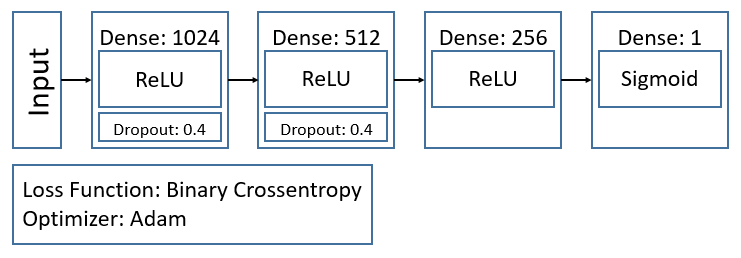

In [ ]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units = 1024,input_dim = 64000)) 
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 512)) 
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 256)) 
    discriminator.add(ReLU())
    
    discriminator.add(Dense(units = 1, activation = "sigmoid"))
    
    discriminator.compile(loss = "binary_crossentropy",
                         optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    return discriminator

d = create_discriminator()
d.summary()

## Simple GANs

* Our Simple GANs' diagram:

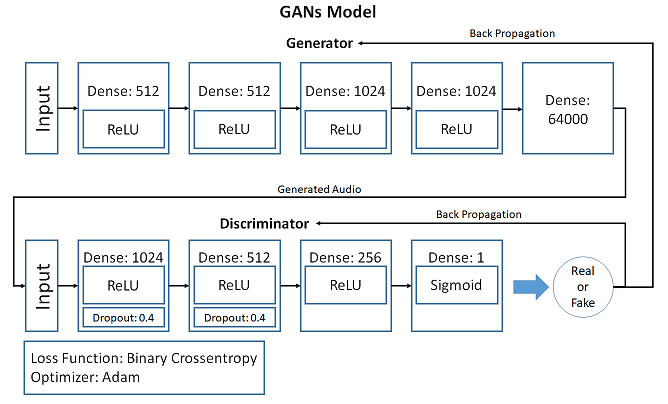

In [ ]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    return gan

gan = create_gan(d,g)
gan.summary()

In [ ]:
def show_gen_samples(epochs, samples = 3):
    samplePlot = []
    fig        = plt.figure(figsize = (1, samples))
    noise      = np.random.normal(0, 1, (samples,100))
    audios     = g.predict(noise)        
    for i, audio in enumerate(audios):
        IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))
        samplePlot.append(fig.add_subplot(1, samples, i+1))
        samplePlot[i].plot(audio.flatten(), '-', )
    plt.gcf().set_size_inches(25, 5)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    fig.suptitle("{} Epochs Result".format(epochs), fontsize = 17)
    plt.show()

<a id="5"></a> <br>
# Training
* In trainig each epoch is a round between Generator and Discriminator. First we are giving a noise to our Generator. Then giving real data and generated data to Discriminator labeling real data as 1 generated as 0. After that we are turning off trainable parameter of Discriminator, generating new images and labeling them as 1 and train DCGAN on these images.
* **Our training diagram:**

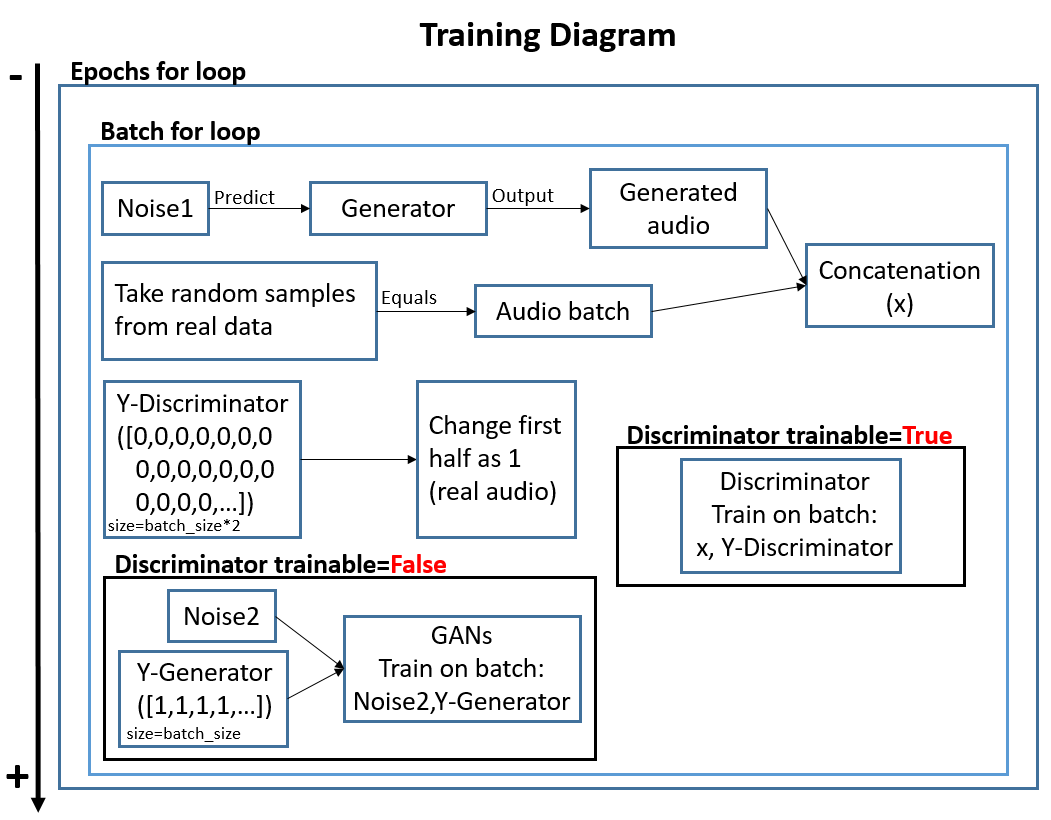

In [ ]:
import time

D_loss = []
G_loss = []
epochs = 40 
batch_size = 128
current_time = time.time()

for e in range(epochs):
    start_time = time.time()
    for _ in range(batch_size):
        # I reccomend you to look "Training Diagram" (at the top) 
        noise = np.random.normal(0,1, [batch_size,100])
        
        generated_audio = g.predict(noise)
       
        audio_batch = x_train[np.random.randint(low = 0, high = x_train.shape[0], size = batch_size)] #get samples from real data
        
        x = np.concatenate([audio_batch, generated_audio])
        
        y_dis = np.zeros(batch_size*2) 
        y_dis[:batch_size] = 1 # we labeled real audios as 1 and generated audios as 0
        
        d.trainable = True
        d_loss = d.train_on_batch(x,y_dis) # we are training discriminator (train_on_batch)
        
        noise = np.random.normal(0,1,[batch_size,100])
        
        y_gen = np.ones(batch_size) # our generator says "these audios are real"
        
        d.trainable = False
        
        g_loss = gan.train_on_batch(noise, y_gen) #train_on_batch
        
        D_loss.append(d_loss)
        G_loss.append(g_loss)
        
    if (e%2 == 0) or (e == epochs-1) :
        print("epochs: ",e)
    if e == epochs-1:
        print("Time since start: {}".format(np.round(start_time - current_time)))
        print("Training Complete.")
    
    # printing results
    if e%10 == 0:
        print("Time since start: {}".format(np.round(start_time - current_time)))
        show_gen_samples(e)

In [ ]:
g.save("audio_generator.h5") # you can donwload this model from output part of this kernel.
d.save("audio_discriminator.h5") # you can donwload this model from output part of this kernel.

<a id="6"></a> <br>
# Results

In [ ]:
index = 0
D_loss2 = []
G_loss2 = []

for i in range(1,epochs+1):
    D_loss2.append(D_loss[index])
    G_loss2.append(G_loss[index])
    index += batch_size

fig, axs = plt.subplots(2, 1, figsize = (12,10))

axs[0].plot(D_loss2, label = "Discriminator Loss")
axs[1].plot(G_loss2, label = "Generator Loss", color = "orange")

axs[0].set_xlabel("Epochs")
axs[1].set_xlabel("Epochs")

axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Loss")

axs[0].set_title("Discriminator Loss")
axs[1].set_title("Generator Loss")
plt.show()

In [ ]:
show_gen_samples(epochs = epochs)

# Denoising with Autoencoder
* Now, our result is noisy but we can clear that noise with **autoencoders**.

* If you do mot know autoencoders you can check out this notebook: https://www.kaggle.com/mrhippo/denoising-mnist-with-autoencoders

In [ ]:
x_train_one_second = []

for file in x_train:
    for x in range(0, 64):
        x_train_one_second.append(file[1000*x:1000*(x+1)])
        
x_train_one_second = np.array(x_train_one_second)

In [ ]:
IPython.display.display(ipd.Audio(data = x_train_one_second[0], rate = SAMPLE_RATE))

In [ ]:
fake_labels = np.random.randint(0, 10, size = (x_train_one_second.shape[0]))

x_train_autoencoder, x_test_autoencoder, _, _ = train_test_split(x_train_one_second, fake_labels, test_size=0.3, random_state=42, shuffle = False)

In [ ]:
noise = 0.2

x_train_autoencoder_noise = x_train_autoencoder + noise*np.random.normal(-1, 1, size = x_train_autoencoder.shape)
x_test_autoencoder_noise = x_test_autoencoder + noise*np.random.normal(-1, 1, size = x_test_autoencoder.shape)

x_train_autoencoder_noise = np.clip(x_train_autoencoder_noise, -1, 1)
x_test_autoencoder_noise = np.clip(x_test_autoencoder_noise, -1, 1)

In [ ]:
noisy_samples = [x_train_autoencoder_noise[1], x_train_autoencoder_noise[3], x_train_autoencoder_noise[10]]

for noisy in noisy_samples:
    IPython.display.display(ipd.Audio(data = noisy, rate = SAMPLE_RATE))

In [ ]:
# Input
input_img = Input(shape = (x_train_autoencoder_noise.shape[1], )) 

# Encoding
encoded = Dense(128, activation = "relu")(input_img) 
encoded = Dense(64, activation = "relu")(encoded) 

# Bottleneck
encoded = Dense(32, activation = "relu")(encoded)

# Decoding
decoded = Dense(64, activation = "relu")(encoded)
decoded = Dense(128, activation = "relu")(decoded)

# Output
decoded = Dense(x_train_autoencoder_noise.shape[1], activation = "sigmoid")(decoded)

autoencoder = Model(input_img, decoded) # Autoencoder

autoencoder.compile(loss = "binary_crossentropy",
                   optimizer = "rmsprop") #rmsprop

autoencoder.summary()

In [ ]:
hist = autoencoder.fit(x_train_autoencoder_noise, x_train_autoencoder, # x_train_autoencoder_noise
                       epochs = 5, 
                       shuffle = True, 
                       batch_size = 16, 
                       validation_data = (x_test_autoencoder_noise, x_test_autoencoder)) # x_test_autoencoder_noise

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(hist.history["loss"], label = "Train Loss")
plt.plot(hist.history["val_loss"], label = "Test Loss")
plt.title("Losses")
plt.legend()
plt.show()

In [ ]:
denoised = autoencoder.predict(x_test_autoencoder_noise)
noisy_samples = [denoised[1], denoised[3], denoised[10]]

for noisy in noisy_samples:
    IPython.display.display(ipd.Audio(data = noisy, rate = SAMPLE_RATE))

In [ ]:
xd = [x_test_autoencoder_noise[1], x_test_autoencoder_noise[3], x_test_autoencoder_noise[10]]

for noisy in xd:
    IPython.display.display(ipd.Audio(data = noisy, rate = SAMPLE_RATE))

In [ ]:
fft = np.fft.fft(denoised[1])

magnitude = np.abs(fft)
freq = np.linspace(0, 16000, len(magnitude))

plt.figure(figsize = (15, 8))
plt.plot(freq, magnitude)
plt.title("Fast Fourier Transform")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
fft = np.fft.fft(x_train_autoencoder_noise[1])

magnitude = np.abs(fft)
freq = np.linspace(0, 16000, len(magnitude))

plt.figure(figsize = (15, 8))
plt.plot(freq, magnitude)
plt.title("Fast Fourier Transform")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(denoised[1])
plt.show()

plt.figure(figsize = (15, 6))
plt.plot(x_train_autoencoder_noise[1])
plt.show()

plt.figure(figsize = (15, 6))
plt.plot(x_train_autoencoder[1])
plt.show()


In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(denoised[1][:500])
plt.show()

plt.figure(figsize = (15, 6))
plt.plot(x_train_autoencoder_noise[1][:500])
plt.show()

plt.figure(figsize = (15, 6))
plt.plot(x_train_autoencoder[1][:500])
plt.show()

<a id="7"></a> <br>
# Conclusion
* **You can download this model from Output part of the kernel.**

### You can check my other kernels here: https://www.kaggle.com/mrhippo/notebooks
* **My other GANs projects:**
* https://www.kaggle.com/mrhippo/fashion-dataset-gans
* https://www.kaggle.com/mrhippo/abstract-art-dcgans


* **If there is something wrong with this kernel please let me know in the comments.**


* **References:**
* https://github.com/rafalencar1997/Audio_Generation
* https://medium.com/neuronio/audio-generation-with-gans-428bc2de5a89